In [1]:
import pandas as pd
import numpy as np
import streamlit as st
from matplotlib import pyplot as plt # Matplotlib
import datetime
from datetime import datetime

# Package to implement ML Algorithms
import sklearn
from sklearn.tree import DecisionTreeRegressor     # Decision Tree
from sklearn.ensemble import RandomForestRegressor # Random Forest

# Package for data partitioning
from sklearn.model_selection import train_test_split

# Package for generating confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Package for generating classification report
from sklearn.metrics import classification_report

# Import packages to implement Stratified K-fold CV
from sklearn.model_selection import KFold # For creating folds

# Import Package to implement GridSearch CV
from sklearn.model_selection import GridSearchCV

# Importing package for Randomized Search CV
from sklearn.model_selection import RandomizedSearchCV

# Package to record time
import time

# Package for Data pretty printer
from pprint import pprint

# Module to save and load Python objects to and from files
import pickle 

# Ignore Deprecation Warnings
import warnings
warnings.filterwarnings('ignore')

# Display inline plots as vector-based (svg)
%config InlineBackend.figure_formats = ['svg']

%matplotlib inline

from xgboost import XGBClassifier

In [2]:
traffic = pd.read_csv("traffic_clean.csv")
traffic.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,traffic_volume,month,day,hour
0,NaN,288.28,0.0,0.0,40,Clouds,5545,October,Tuesday,9
1,NaN,289.36,0.0,0.0,75,Clouds,4516,October,Tuesday,10
2,NaN,289.58,0.0,0.0,90,Clouds,4767,October,Tuesday,11
3,NaN,290.13,0.0,0.0,90,Clouds,5026,October,Tuesday,12
4,NaN,291.14,0.0,0.0,75,Clouds,4918,October,Tuesday,13


In [51]:
traffic.index.size

48204

In [3]:
traffic["holiday"].replace(np.nan, "None", inplace=True)
traffic["holiday"] = traffic["holiday"].astype(str)
traffic["holiday"].value_counts(normalize=True)

holiday
None                         0.998735
Labor Day                    0.000145
Thanksgiving Day             0.000124
Christmas Day                0.000124
New Years Day                0.000124
Martin Luther King Jr Day    0.000124
Columbus Day                 0.000104
Veterans Day                 0.000104
Washingtons Birthday         0.000104
Memorial Day                 0.000104
Independence Day             0.000104
State Fair                   0.000104
Name: proportion, dtype: float64

In [4]:
#getting ready for ml algorithms
X = traffic.drop(columns = ["traffic_volume"])
y =traffic["traffic_volume"]

In [5]:
# One hot encoding for categorical variables
cat_var = ["holiday", "weather_main", "month", "day"]
X_encoded = pd.get_dummies(X, columns = cat_var)

X_encoded.head()

,temp,rain_1h,snow_1h,clouds_all,hour,holiday_Christmas Day,holiday_Columbus Day,holiday_Independence Day,holiday_Labor Day,holiday_Martin Luther King Jr Day,...,month_November,month_October,month_September,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
0,288.28,0.0,0.0,40,9,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
1,289.36,0.0,0.0,75,10,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
2,289.58,0.0,0.0,90,11,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
3,290.13,0.0,0.0,90,12,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
4,291.14,0.0,0.0,75,13,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False


In [6]:
# Data partitioning into train and test sets
train_X, test_X, train_y, test_y = train_test_split(X_encoded, y, test_size = 0.2, random_state = 42)

In [23]:
#random forest best model
regressor = RandomForestRegressor(random_state = 42)
folds = KFold(n_splits = 3, shuffle = True, random_state = 42)
param_grid = {
    'max_depth': [21],
    'min_samples_leaf': [4],
    'min_samples_split': [9],
    'n_estimators': [350]
}
#max_depth': 21, 'min_samples_leaf': 4, 'min_samples_split': 9, 'n_estimators': 350

In [24]:
# Call GridSearchCV()
model_cv = GridSearchCV(estimator = regressor, 
                        param_grid = param_grid, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        n_jobs = -1)

In [25]:
# Fit the model
start = time.time()            # Start Time
model_cv.fit(train_X, train_y)  
stop = time.time()             # End Time
print(f"Training time: {stop - start}s")
print('Improved score: ', model_cv.best_score_)
print('Improved parameters: ', model_cv.best_params_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


Training time: 138.3163321018219s
Improved score:  0.9469978962439463
Improved parameters:  {'max_depth': 21, 'min_samples_leaf': 4, 'min_samples_split': 9, 'n_estimators': 350}


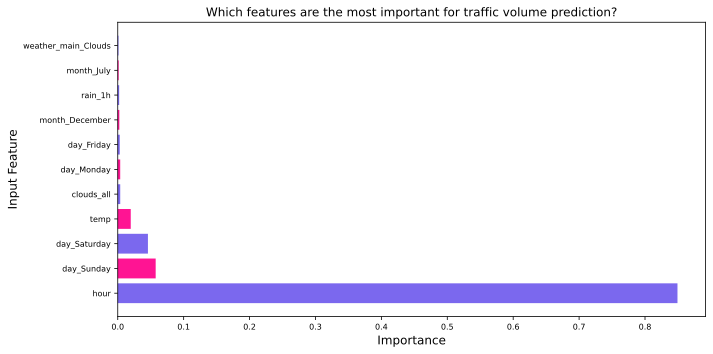

In [31]:
# Storing importance values from the trained model
importance = model_cv.best_estimator_.feature_importances_

# Storing feature importance as a dataframe
feature_imp = pd.DataFrame(list(zip(train_X.columns, importance)),
               columns = ['Feature', 'Importance'])

feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)
feature_imp = feature_imp[feature_imp['Importance'] > 0.001]
# Bar plot
plt.figure(figsize=(10, 5))
plt.barh(feature_imp['Feature'], feature_imp['Importance'], color = ['mediumslateblue', 'deeppink'])

plt.xlabel("Importance", fontsize = 12)
plt.ylabel("Input Feature", fontsize = 12)
plt.title('Which features are the most important for traffic volume prediction?', fontsize = 12) 
plt.yticks(fontsize = 8) # fontsize of yticks
plt.xticks(fontsize = 8) # fontsize of xticks
plt.savefig("rf_feature_imp.svg", bbox_inches="tight")
plt.tight_layout();

In [13]:
from sklearn.metrics import mean_squared_error
y_pred = model_cv.predict(train_X)
mean_squared_error(train_y, y_pred, squared=False)

339.7317786567012

In [50]:
# Creating the file where we want to write the model
rf_pickle = open('rf_traffic.pickle', 'wb') 

# Write RF model to the file
pickle.dump(model_cv, rf_pickle) 

# Close the file
rf_pickle.close()

In [36]:
#decision tree model
regressor = DecisionTreeRegressor(random_state = 42)
folds = KFold(n_splits = 3, shuffle = True, random_state = 42)
param_grid = {
    'max_depth': [89],
    'min_samples_leaf': [9],
    'min_samples_split': [64]
}
#'max_depth': 89, 'min_samples_leaf': 9, 'min_samples_split': 64

In [37]:
# Call GridSearchCV()
model_cv = GridSearchCV(estimator = regressor, 
                        param_grid = param_grid, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        n_jobs = -1)

In [38]:
# Fit the model
start = time.time()            # Start Time
model_cv.fit(train_X, train_y)  
stop = time.time()             # End Time
print(f"Training time: {stop - start}s")
print('Improved score: ', model_cv.best_score_)
print('Improved parameters: ', model_cv.best_params_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 3.5071208477020264s
Improved score:  0.9393871334641242
Improved parameters:  {'max_depth': 89, 'min_samples_leaf': 9, 'min_samples_split': 64}


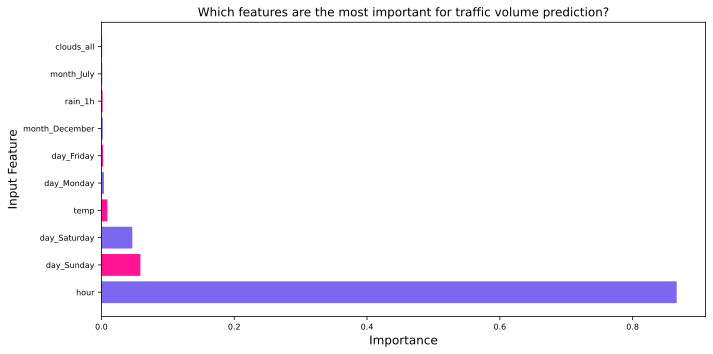

In [39]:
# Storing importance values from the trained model
importance = model_cv.best_estimator_.feature_importances_

# Storing feature importance as a dataframe
feature_imp = pd.DataFrame(list(zip(train_X.columns, importance)),
               columns = ['Feature', 'Importance'])

feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)
feature_imp = feature_imp[feature_imp['Importance'] > 0.001]
# Bar plot
plt.figure(figsize=(10, 5))
plt.barh(feature_imp['Feature'], feature_imp['Importance'], color = ['mediumslateblue', 'deeppink'])

plt.xlabel("Importance", fontsize = 12)
plt.ylabel("Input Feature", fontsize = 12)
plt.title('Which features are the most important for traffic volume prediction?', fontsize = 12) 
plt.yticks(fontsize = 8) # fontsize of yticks
plt.xticks(fontsize = 8) # fontsize of xticks
plt.savefig("dt_feature_imp.svg", bbox_inches="tight")
plt.tight_layout();

In [17]:
y_pred = model_cv.predict(train_X)
mean_squared_error(train_y, y_pred, squared=False)

434.77509443380814

In [31]:
# Creating the file where we want to write the model
dt_pickle = open('dt_traffic.pickle', 'wb') 

# Write RF model to the file
pickle.dump(model_cv, dt_pickle) 

# Close the file
dt_pickle.close()

In [18]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import StratifiedKFold

In [40]:
regressor = AdaBoostRegressor(random_state=42)
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

In [ ]:
'''
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 500, num = 10)]

learning_rate = [x for x in np.arange(0.1, 2.1, 0.1)]

param_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate
}

model_cv = RandomizedSearchCV(estimator = regressor,
                              param_distributions = param_grid,
                              n_iter = 100,
                              scoring = 'f1_macro',
                              cv = folds,
                              verbose = 2,
                              random_state = 42,
                              n_jobs = -1)
'''

In [41]:
#best model:
#'learning_rate': 0.1, 'n_estimators': 65
param_grid = {'n_estimators': [65],
               'learning_rate': [0.1]
}

In [42]:
# Call GridSearchCV()
model_cv = GridSearchCV(estimator = regressor, 
                        param_grid = param_grid, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        n_jobs = -1)

In [43]:
# Fit the model
start = time.time()            # Start Time
model_cv.fit(train_X, train_y)  
stop = time.time()             # End Time
print(f"Training time: {stop - start}s")
print('Improved score: ', model_cv.best_score_)
print('Improved parameters: ', model_cv.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Training time: 37.00531768798828s
Improved score:  0.8168258819731143
Improved parameters:  {'learning_rate': 0.1, 'n_estimators': 65}


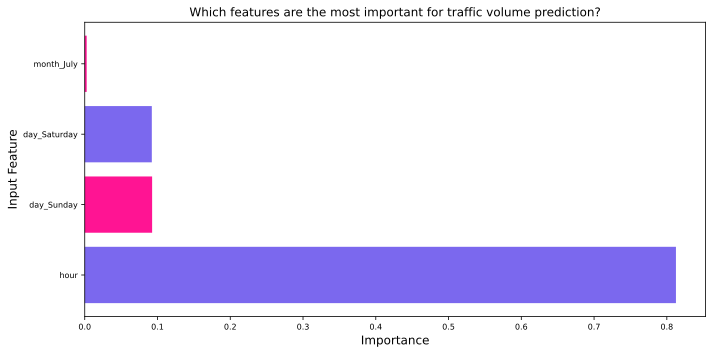

In [44]:
# Storing importance values from the trained model
importance = model_cv.best_estimator_.feature_importances_

# Storing feature importance as a dataframe
feature_imp = pd.DataFrame(list(zip(train_X.columns, importance)),
               columns = ['Feature', 'Importance'])

feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)
feature_imp = feature_imp[feature_imp['Importance'] > 0.001]
# Bar plot
plt.figure(figsize=(10, 5))
plt.barh(feature_imp['Feature'], feature_imp['Importance'], color = ['mediumslateblue', 'deeppink'])

plt.xlabel("Importance", fontsize = 12)
plt.ylabel("Input Feature", fontsize = 12)
plt.title('Which features are the most important for traffic volume prediction?', fontsize = 12) 
plt.yticks(fontsize = 8) # fontsize of yticks
plt.xticks(fontsize = 8) # fontsize of xticks
plt.savefig("ad_feature_imp.svg", bbox_inches="tight")
plt.tight_layout();

In [45]:
y_pred = model_cv.predict(train_X)
mean_squared_error(train_y, y_pred, squared=False)

853.1444959493662

In [17]:
#saving adaboost model
ad_pickle = open('ad_traffic.pickle', 'wb') 

# Write RF model to the file
pickle.dump(model_cv, ad_pickle) 

# Close the file
ad_pickle.close()

In [46]:
#XGBOOST MODEL
from xgboost import XGBRegressor

In [47]:
regressor = XGBRegressor(seed=27)

In [21]:
'''
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

param_grid = {'n_estimators': [5, 50, 100, 200],
               'learning_rate': [0.1, 1, 1.5, 2],
               'max_depth': [5, 7, 9],
               'min_child_weight': [1, 3, 5]
}

model_cv = RandomizedSearchCV(estimator = regressor,
                              param_distributions = param_grid,
                              n_iter = 100,
                              scoring = 'r2',
                              cv = folds,
                              verbose = 2,
                              random_state = 42,
                              n_jobs = -1)
'''

In [48]:
#'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 4, 'n_estimators': 210
param_grid = {'n_estimators': [10],
               'learning_rate': [0.1],
               'max_depth': [10],
               'min_child_weight': [4]
}

# Call GridSearchCV()
model_cv = GridSearchCV(estimator = regressor, 
                        param_grid = param_grid, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        n_jobs = -1)

In [49]:
# Fit the model
start = time.time()            # Start Time
model_cv.fit(train_X, train_y)  
stop = time.time()             # End Time
print(f"Training time: {stop - start}s")
print('Improved score: ', model_cv.best_score_)
print('Improved parameters: ', model_cv.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Training time: 2.8977091312408447s
Improved score:  0.8261706930917037
Improved parameters:  {'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 4, 'n_estimators': 10}


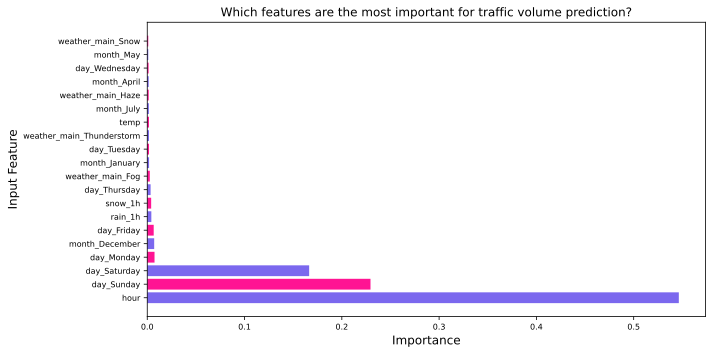

In [50]:
# Storing importance values from the trained model
importance = model_cv.best_estimator_.feature_importances_

# Storing feature importance as a dataframe
feature_imp = pd.DataFrame(list(zip(train_X.columns, importance)),
               columns = ['Feature', 'Importance'])

feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)
feature_imp = feature_imp[feature_imp['Importance'] > 0.001]
# Bar plot
plt.figure(figsize=(10, 5))
plt.barh(feature_imp['Feature'], feature_imp['Importance'], color = ['mediumslateblue', 'deeppink'])

plt.xlabel("Importance", fontsize = 12)
plt.ylabel("Input Feature", fontsize = 12)
plt.title('Which features are the most important for traffic volume prediction?', fontsize = 12) 
plt.yticks(fontsize = 8) # fontsize of yticks
plt.xticks(fontsize = 8) # fontsize of xticks
plt.savefig("xg_feature_imp.svg", bbox_inches="tight")
plt.tight_layout();

In [51]:
y_pred = model_cv.predict(train_X)
mean_squared_error(train_y, y_pred, squared=False)

817.9630554761285

In [27]:
#saving adaboost model
xg_pickle = open('xg_traffic.pickle', 'wb') 

# Write RF model to the file
pickle.dump(model_cv, xg_pickle) 

# Close the file
xg_pickle.close()

In [10]:
traffic["weather_main"].unique().tolist()

['Clouds',
 'Clear',
 'Rain',
 'Drizzle',
 'Mist',
 'Haze',
 'Fog',
 'Thunderstorm',
 'Snow',
 'Squall',
 'Smoke']

In [52]:
models = ["Decision Tree", "Random Forest", "AdaBoost", "XGBoost"]
r2 = [0.94699, 0.93939, 0.81683, 0.82617]
rmse = [339.73178, 434.77509, 853.14449, 817.96306]
metrics = pd.DataFrame(list(zip(models, r2, rmse)), 
                       columns = ["ML Model", "R2", "RMSE"])
metrics

,ML Model,R2,RMSE
0,Decision Tree,0.94699,339.73178
1,Random Forest,0.93939,434.77509
2,AdaBoost,0.81683,853.14449
3,XGBoost,0.82617,817.96306


In [74]:
def color_val(df):
    if df["ML Model"] == "Decision Tree":
        return ['background-color: limegreen']*3
    elif df["ML Model"] == "AdaBoost":
        return ['background-color: orange']*3
    else:
        return ''

In [75]:
metrics2 = metrics.style.apply(color_val, axis=1)
metrics2

,ML Model,R2,RMSE
0,Decision Tree,0.946990,339.731780
1,Random Forest,0.939390,434.775090
2,AdaBoost,0.816830,853.144490
3,XGBoost,0.826170,817.963060


In [68]:
metrics.to_csv("metric.csv", index=False)